In [1]:
from hopfield_modern.hopfield_modern import Hopfield

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint
from tqdm.notebook import tqdm, tqdm_notebook
from typing import Callable
import numpy
import itertools as it

In [3]:
def norm(prediction, data):
    t = prediction - data
    # print(np.linalg.norm(t))
    return 1 - np.linalg.norm(t)
    # return np.sum(np.abs(data))
    
    
def norm2(prediction, data):
    t = (prediction - data)
    return 1/(np.linalg.norm(t) + 1)


In [4]:
def softmax(data):
    t = np.exp(data - np.max(data))
    return t/np.sum(t)

In [5]:
def load_dir(dataset: list, path: str, label: bool, sort=True):
    dataset.sort(key=lambda e: e["id"])
    if dataset:
        index = dataset[-1]["id"]+1
    else:
        index = 0
    fnames = [(path+"/Red/"+i[:2]+"_Red.txt", path+"/Green/"+i[:2]+"_Green.txt",path+"/Blue/"+i[:2]+"_Blue.txt") for i in [i for i in os.walk(path)][1][2]]
    for fname in fnames:
        person = {"id": index}
        person["label"] = label
        with open(fname[0],"r") as rfile, open(fname[1],"r") as gfile, open(fname[2],"r") as bfile:
            person["r"] = [float(i) for i in rfile.readlines()[1:]]
            person["g"] = [float(i) for i in gfile.readlines()[1:]]
            person["b"] = [float(i) for i in bfile.readlines()[1:]]
        
        if sort:
            person["r"].sort()
            person["g"].sort()            
            person["b"].sort()
        
        index+=1
        dataset.append(person)
        
def load_dataset(dataset: list, path: str, pathpos: str, pathneg: str, sort=True):
    load_dir(dataset, path+"/"+pathpos, True, sort=sort)
    load_dir(dataset, path+"/"+pathneg, False, sort=sort)    
        
        
# def get_filter(dataset: list, filter: str):
#     if filter!="r" and filter!="g" and filter!="b":
#         raise ValueError('Wrong filter: must be "r", "g", "b"')
#     new_dataset = []
#     for person in dataset:
#         new_dataset.append({"id": person["id"], "label": person["label"], "data": person[filter]})
    
#     return new_dataset

def show_plot_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for i in np.arange(0,len(dataset), 1):
        color="green"
        if dataset[i]["label"]:
            color="red"
        for j in dataset[i][filter]:
            plt.plot(i,j, "o", markersize=0.5, color=color)
    plt.show()

    
def binarize_person(person: dict, precision=1e-3, up=1.8, down=0.2, radius=0, flatten=True, filters=3):
    person_data = np.zeros((3, int((up-down)//precision)+1), np.float32)[0:filters]
    
    dots  = (
        ((np.array(person["r"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["g"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["b"]).clip(down, up)-down)//precision).astype(np.uint32))[0:filters]

    
    for color_index in range(filters):
        for dot in dots[color_index]:
            person_data[color_index][max(0, dot-radius) : min(dot+radius+1, person_data.shape[1])].fill(1)
    
    if flatten:
        return {"id": person["id"], "label": person["label"], "data": person_data.flatten()}
    else:
        return {"id": person["id"], "label": person["label"], "data": person_data}

def binarize_person_by_filter(person: dict, precision=1e-3, up=1.8, down=0.2, radius=0, flatten=True, filter='g'):
    person_data = np.zeros((int((up-down)//precision)+1), np.float32)
    
    dots  = ((np.array(person[filter]).clip(down, up)-down)//precision).astype(np.uint32)

    
    for dot in dots:
        person_data[max(0, dot-radius) : min(dot+radius+1, person_data.shape[0])].fill(1)
    
    if flatten:
        return {"id": person["id"], "label": person["label"], "data": person_data.flatten()}
    else:
        return {"id": person["id"], "label": person["label"], "data": person_data}





def show_plot_avg_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for person in dataset:
        
        if person["label"]:
            color="red"
            x = 0
        else:
            color="green"
            x = 1
             
        for y in person[filter]:
            plt.plot(x,y, "o", markersize=0.5, color=color)
    plt.show()
    


In [116]:
def max_score_i(dataset: np.ndarray, X: np.ndarray, i: int, score_fn: Callable):
    if i==0:
        max_i = 1
    else:
        max_i = 0
    # print(f"len {len(dataset)}")
    for j in (k for k in range(len(dataset)) if k!=i):
        if score_fn(X,dataset[max_i]) <= score_fn(X,dataset[j]):
            max_i = j
            
    return max_i

In [128]:
N = 58
dataset = []
load_dataset(dataset, "C:/Users/User/Desktop/Data/Data", "BC", "Control", sort=True)
# pos = random.sample(dataset[:68], N//2)
# neg = random.sample(dataset[68:], N//2)
pos = dataset[:68]
neg = dataset[68:]

dataset = np.concatenate([pos, neg]).tolist()
random.shuffle(dataset)
print(len(dataset))
# assert sum([i['label'] for i in dataset])*2 == N

97


1.0 -1.0
0.6024844720496895


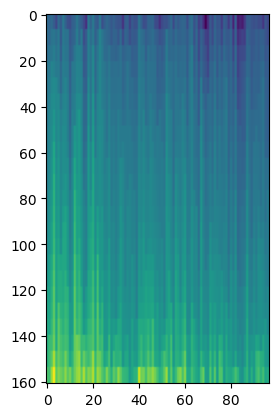

In [118]:
num_of_dims = 23
filter = 'b'
image_scaling = 7

dataset_dim = np.array([{'data': random.sample(person[filter], num_of_dims),
                           'label': person['label'],
                           'id': person['id']
                           } for person in dataset])

dataset_color = np.array([i['data'] for i in dataset_dim])
dataset_color = np.array([np.concatenate([i]*image_scaling) for i in dataset_color])


for p in dataset_color:
    p.sort()
    
dataset_color -= dataset_color.min()
dataset_color /= dataset_color.max()
# dataset_color = softmax(dataset_color) # not!!!

dataset_color = dataset_color*2-1

plt.imshow(dataset_color.T)

print(dataset_color.max(), dataset_color.min())
print((dataset_color.shape[0]/dataset_color.shape[1]))

In [119]:
result = []
answer = []
maxs = []


for i in tqdm_notebook(range(len(dataset_color))):
    
    _mask = np.ones(len(dataset_color), dtype=bool)
    _mask[i] = False

    _X = dataset_color[i]
    _images = dataset_color[_mask]
    
    model = Hopfield(_images.T.copy())

    out = model.run(_X, 16.0)
    
    max_i = max_score_i(dataset=dataset_color, X=out, i=i, score_fn=norm2)
    maxs.append(max_i)
    
    print(max_i, end=" ")
    
    answer.append(dataset_dim[max_i]["label"])
    if dataset_dim[max_i]["label"]==dataset_dim[i]["label"]:
        result.append(1)
    else:
        result.append(0)
    
    
print("")
score = sum(result)/len(dataset_dim)
print(score)

  0%|          | 0/97 [00:00<?, ?it/s]

16 3 3 12 3 3 3 3 3 3 83 16 3 3 3 3 83 83 3 3 3 16 3 3 3 83 83 3 83 83 83 16 16 83 83 83 83 83 83 83 3 16 16 83 16 16 16 83 83 83 83 83 3 81 16 83 3 16 83 16 3 83 83 3 83 83 83 3 83 83 83 83 83 16 83 83 83 83 83 83 83 83 83 84 83 83 83 16 83 83 83 83 83 83 83 83 83 
0.6804123711340206


In [135]:
def test(test_iterations, filter = 'r', beta= [16]):
    num_of_dims = 23
    # filter = 'r'
    # image_scaling = 1

    tests = []
    for b in beta:
        result = []
        answer = []
        maxs = []
        for t in tqdm_notebook(range(test_iterations)):

            dataset_dim = np.array([{'data': random.sample(person[filter], num_of_dims),
                                       'label': person['label'],
                                       'id': person['id']
                                       } for person in dataset])

            dataset_color = np.array([i['data'] for i in dataset_dim])
            # dataset_color = np.array([np.concatenate([i]*image_scaling) for i in dataset_color])


            for p in dataset_color:
                p.sort()

            dataset_color -= dataset_color.min()
            dataset_color /= dataset_color.max()
            # dataset_color = softmax(dataset_color) # not!!!

            dataset_color = dataset_color*2-1

            for i in (range(len(dataset_color))):

                _mask = np.ones(len(dataset_color), dtype=bool)
                _mask[i] = False

                _X = dataset_color[i]
                _images = dataset_color[_mask]

                model = Hopfield(_images.T.copy())

                out = model.run(_X, 16.0)

                max_i = max_score_i(dataset=dataset_color, X=out, i=i, score_fn=norm2)
                maxs.append(max_i)

                # print(max_i, end=" ")

                answer.append(dataset_dim[max_i]["label"])
                if dataset_dim[max_i]["label"]==dataset_dim[i]["label"]:
                    result.append(1)
                else:
                    result.append(0)
        score = sum(result)/len(dataset_dim)/test_iterations
        tests.append({'beta':b, 'score':score})
    pprint(tests)

In [137]:
test(1000, 'r')
test(1000, 'g')
test(1000, 'b')

  0%|          | 0/1000 [00:00<?, ?it/s]

[{'beta': 16, 'score': 0.6312886597938144}]


  0%|          | 0/1000 [00:00<?, ?it/s]

[{'beta': 16, 'score': 0.5080824742268042}]


  0%|          | 0/1000 [00:00<?, ?it/s]

[{'beta': 16, 'score': 0.679639175257732}]


In [113]:
68/(68+29)

0.7010309278350515